In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams['figure.figsize'] = [16, 9]
from utils import latex_settings
from datetime import timedelta
from scipy import signal
from analysis import *
import pywt
import statsmodels.api as sm

 # Lettura dataset e conversione in datetime

In [2]:
data = pd.read_csv("./Data/daneOkresoweKSE.csv", sep=';', skiprows=1, names=['Date', 'Hour', 'Minute', 'Load'])
Electric = data.copy()
Electric['Date'] = pd.to_datetime(Electric.Date)

In [3]:
data.columns, Electric.columns

(Index(['Date', 'Hour', 'Minute', 'Load'], dtype='object'),
 Index(['Date', 'Hour', 'Minute', 'Load'], dtype='object'))

In [4]:
Electric

,Date,Hour,Minute,Load
0,2008-01-01,0,15,15938.8
1,2008-01-01,0,30,15770.4
2,2008-01-01,0,45,15766.3
3,2008-01-01,1,0,15415.2
4,2008-01-01,1,15,15351.8
...,...,...,...,...
315643,2016-12-31,23,0,15952.7
315644,2016-12-31,23,15,15865.3
315645,2016-12-31,23,30,15693.5
315646,2016-12-31,23,45,15508.3


In [3]:
Electric.loc[Electric.Hour == 24, 'Date'] = Electric.loc[Electric.Hour == 24, 'Date'] + timedelta(days=1)
Electric.loc[Electric.Hour == 24, 'Hour'] = 0

In [4]:
Electric.Date = pd.to_datetime(Electric.Date.astype(str) + ' ' + Electric['Hour'].astype(str) + ':' + Electric.Minute.astype(str) + ':00')
Electric['Seconds'] = (Electric.Date - Electric.Date[0]).dt.total_seconds()
Electric = Electric[['Date', 'Seconds', 'Load']]
Electric['Day'] = Electric['Date'].dt.day_name()
Electric['Minutes'] = Electric['Date'].dt.minute
Electric['Hour'] = Electric['Date'].dt.hour
Electric.columns

Index(['Date', 'Seconds', 'Load', 'Day', 'Minutes', 'Hour'], dtype='object')

In [9]:
Electric.tail()

,Date,Seconds,Load,Day,Minutes,Hour
315643,2016-12-31 23:00:00,284078700.0,15952.7,Saturday,0,23
315644,2016-12-31 23:15:00,284079600.0,15865.3,Saturday,15,23
315645,2016-12-31 23:30:00,284080500.0,15693.5,Saturday,30,23
315646,2016-12-31 23:45:00,284081400.0,15508.3,Saturday,45,23
315647,2017-01-01 00:00:00,284082300.0,15235.2,Sunday,0,0


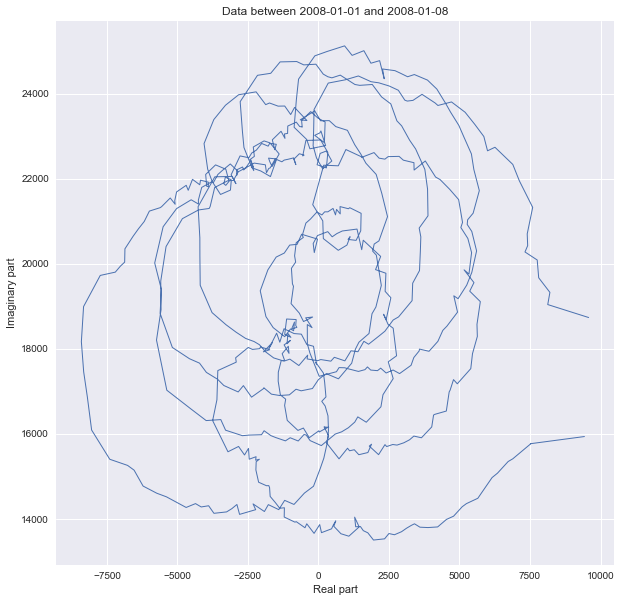

In [10]:
start = '2008-01-01'
thr = '2008-01-08'
HHT = signal.hilbert(Electric[Electric.Date < '2008-01-08'].Load.values)

Re = np.imag(HHT)
Im = np.real(HHT)

plt.figure(figsize=(10,10))
plt.plot(Re, Im, lw=1)
plt.xlabel('Real part')
plt.ylabel('Imaginary part')
plt.title('Data between %s and %s' %(start, thr));

672 = indice corrispondente a 1 settimana in secondi 
<br>35040 = || 1 anno in secondi
<br>96 = indice 1 giorno 

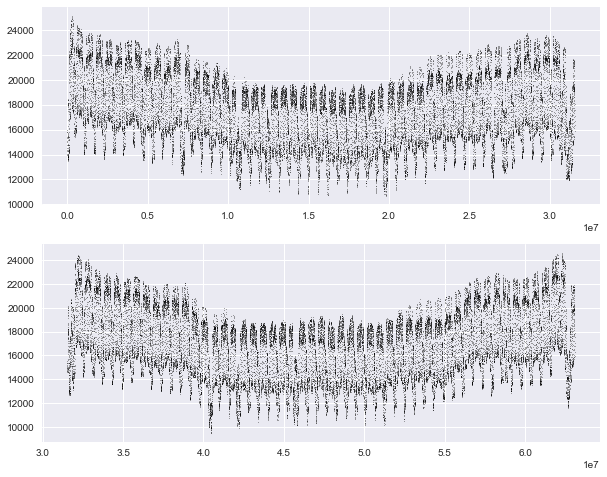

In [11]:
plt.figure(figsize=(10,8))
plt.subplot(211)
plt.plot(Electric.Seconds[:35040], Electric.Load[:35040], '.k', markersize=1)
#plt.xlim(0, 10000000)

plt.subplot(212)
plt.plot(Electric.Seconds[35040:2*35040], Electric.Load[35040:2*35040], '.k', markersize=1)
#plt.xlim(0, 10000000)

In [13]:
Electric

,Date,Seconds,Load,Day,Minutes,Hour
0,2008-01-01 00:15:00,0.0,15938.8,Tuesday,15,0
1,2008-01-01 00:30:00,900.0,15770.4,Tuesday,30,0
2,2008-01-01 00:45:00,1800.0,15766.3,Tuesday,45,0
3,2008-01-01 01:00:00,2700.0,15415.2,Tuesday,0,1
4,2008-01-01 01:15:00,3600.0,15351.8,Tuesday,15,1
...,...,...,...,...,...,...
315643,2016-12-31 23:00:00,284078700.0,15952.7,Saturday,0,23
315644,2016-12-31 23:15:00,284079600.0,15865.3,Saturday,15,23
315645,2016-12-31 23:30:00,284080500.0,15693.5,Saturday,30,23
315646,2016-12-31 23:45:00,284081400.0,15508.3,Saturday,45,23


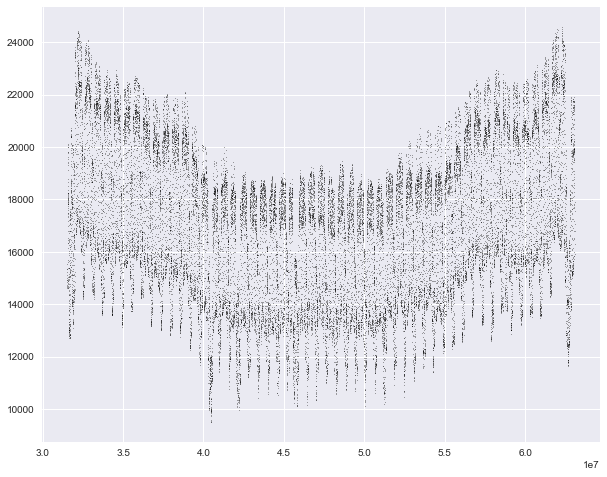

In [14]:
plt.figure(figsize=(10,8))
plt.plot(Electric.Seconds[35040:2*35040], Electric.Load[35040:2*35040], '.k', markersize=1)
#plt.xlim(0, 10000000)

# Fit lineare

In [6]:
params = latex_settings()
mpl.rcParams.update(params)

In [7]:
from scipy.optimize import curve_fit

def lin(x, a, b):
    return a + b * x

popt, pcov = curve_fit(lin, Electric.Seconds, Electric.Load)

lin_load = lin(Electric.Seconds, popt[0], popt[1])

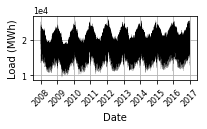

In [8]:
plt.plot(Electric.Date, Electric.Load, 'k', lw=0.1, label='Load')
plt.xlabel('Date')
plt.ylabel('Load (MWh)')
plt.grid()
plt.xticks(rotation=45)

plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.tight_layout()
#plt.savefig('./Images/Poland_Load', dpi=800)

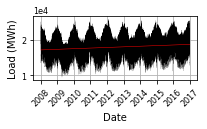

In [9]:
plt.plot(Electric.Date, Electric.Load, 'k', lw=0.1, label='Load')
plt.plot(Electric.Date, lin_load, c='r', lw=0.5, label='Mean Value')
plt.xlabel('Date')
plt.ylabel('Load (MWh)')
plt.grid()
plt.xticks(rotation=45)

plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.tight_layout()
#plt.savefig('./Images/linear_trend', dpi=800)

Ai dati reali vado a togliere i valori del fit lineare, in modo da eliminare l'andamento crescente (verrà aggiunto alla fine dell'analisi).

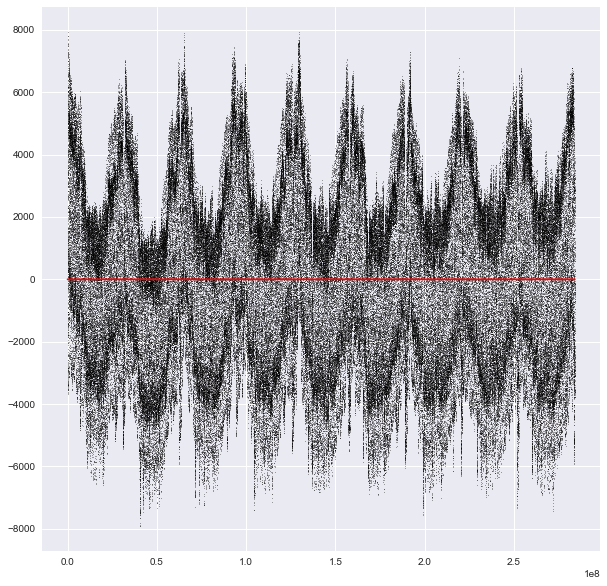

In [6]:
Vol_shift = Electric.Load - lin_load

plt.figure(figsize=(10,10))
plt.plot(Electric.Seconds, Vol_shift, '.k', markersize=1)
plt.plot(Electric.Seconds, np.zeros(len(Electric.Seconds)), c='r');

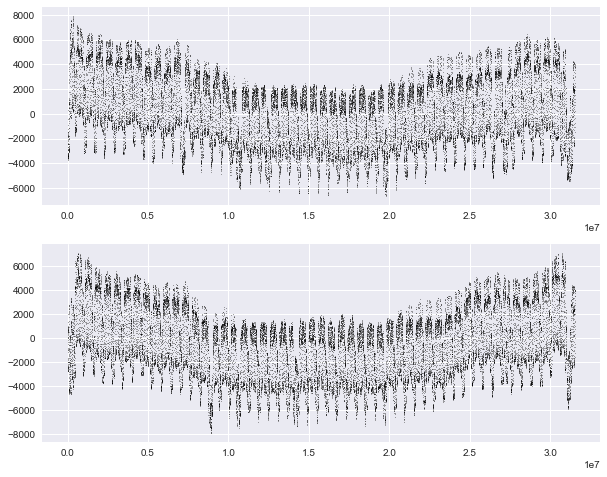

In [17]:
plt.figure(figsize=(10,8))
plt.subplot(211)
plt.plot(Electric.Seconds[:35040], Vol_shift[:35040], '.k', markersize=1)
#plt.xlim(0, 10000000)

plt.subplot(212)
plt.plot(Electric.Seconds[:35040], Vol_shift[35040:2*35040], '.k', markersize=1)
#plt.xlim(0, 10000000)

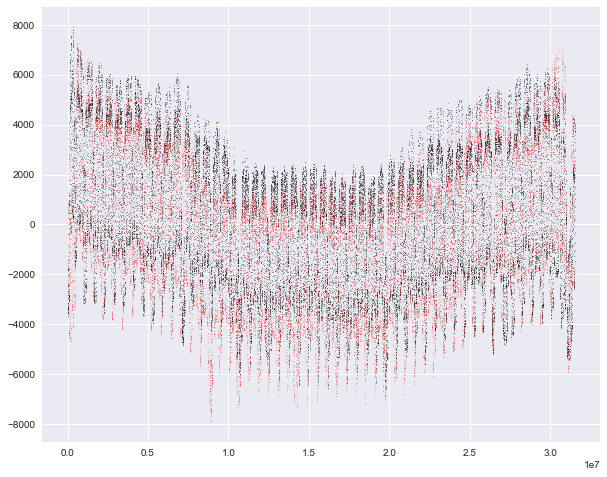

In [17]:
plt.figure(figsize=(10,8))
plt.plot(Electric.Seconds[:35040], Vol_shift[:35040], '.k', markersize=1)
#plt.xlim(0, 10000000)
plt.plot(Electric.Seconds[:35040], Vol_shift[35040:2*35040], '.r', markersize=1, alpha=0.5)
#plt.xlim(0, 10000000)

# Fourier Transforms

<br> 1 ora in secondi -> 2.778 E-4 Hz
<br> 1 giorno in secondi -> 1.157 E-5 Hz
<br> 1 settimana in secondi -> 1.653 E-6 Hz
<br> 1 mese in secondi -> 3.805 E-7 Hz
<br> 1 anno in secondi -> 3.171 E-8  Hz

Text(0.5, 1.0, 'FFT in Frequency Domain')

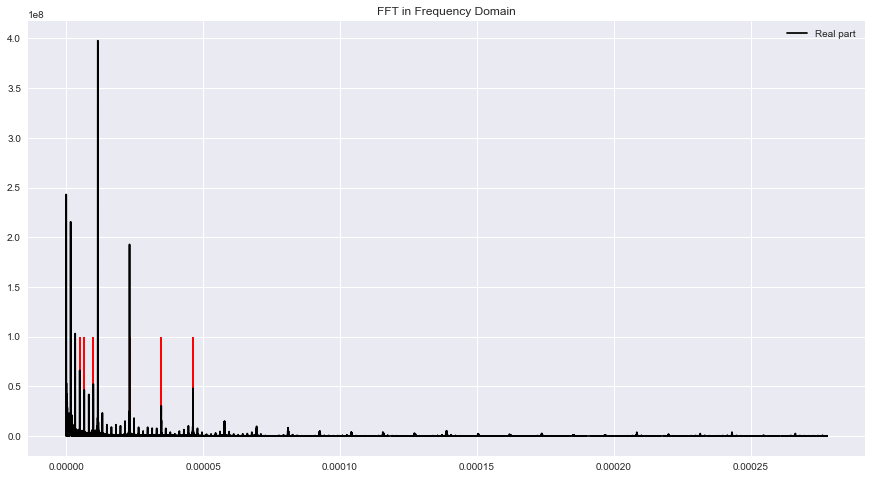

In [18]:
F = np.fft.fft(Vol_shift)

ts = (Electric.Seconds.iloc[-1] - Electric.Seconds.iloc[0])/(Electric.Seconds.size -1)
f = np.linspace(0, 1/(2*ts), Electric.Load.size//2, endpoint=True)
F_abs = np.abs(F)[:len(f)//2]
f = f[:len(f)//2]

freq = np.fft.fftfreq(n=Electric.Load.size, d=1/ts)

peaks, _ = signal.find_peaks(F_abs, threshold=2E7, distance=200)
widths = signal.peak_widths(F_abs, peaks, rel_height=0.97)

plt.figure(figsize=(15,8))
#plt.plot(freq[:len(freq)//2], np.abs(F[:len(freq)//2]), c='k', label="Real part")
plt.plot(f, F_abs, c='k', label="Real part")
plt.plot(f[peaks], F_abs[peaks], 'x')
for i in range(len(widths[0])):
    plt.vlines(f[int(widths[2][i])], 0, 1E8, colors='r')
    plt.vlines(f[int(widths[3][i])], 0, 1E8, colors='r')

plt.legend(loc=1)
#plt.xlim(0,0.000007)
#plt.xlim(0, 0.000002)
#plt.xlim(0.000002,0.000005)
plt.title("FFT in Frequency Domain")

# FFT filtraggio su tutto il segnale

Text(0.5, 1.0, 'FFT in Frequency Domain')

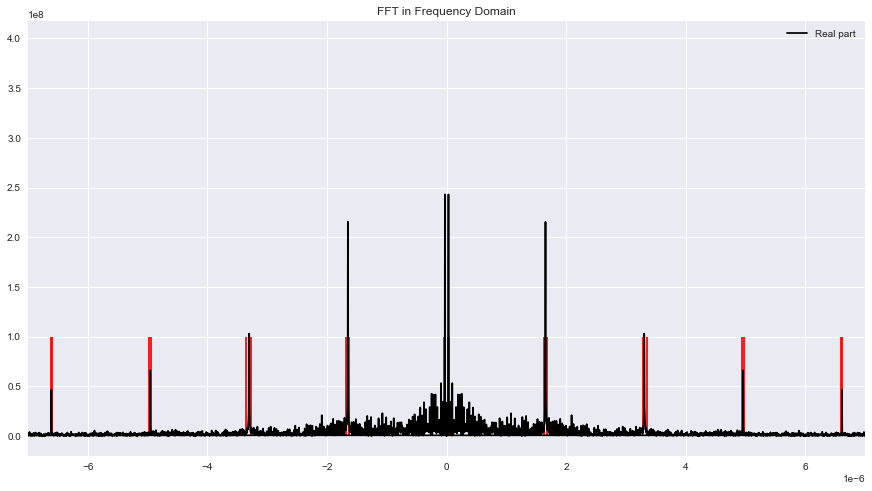

In [19]:
F = np.fft.fft(Vol_shift)

F_abs = np.abs(F)

f_pos = np.linspace(0, 1/(2*ts), Electric.Load.size//2)
f_neg = np.linspace(-1/(2*ts), 0, Electric.Load.size//2, endpoint=True)

f = np.concatenate((f_pos, f_neg))

peaks, _ = signal.find_peaks(F_abs, threshold=2E7, distance=200)
widths = signal.peak_widths(F_abs, peaks, rel_height=0.97)

plt.figure(figsize=(15,8))
#plt.plot(freq[:len(freq)//2], np.abs(F[:len(freq)//2]), c='k', label="Real part")
plt.plot(f, F_abs, c='k', label="Real part")
plt.plot(f[peaks] ,F_abs[peaks], 'x')
for i in range(len(widths[2])):
    plt.vlines(f[int(widths[2][i])], 0, 1E8, colors='r')
    plt.vlines(f[int(widths[3][i])], 0, 1E8, colors='r')

plt.legend(loc=1)
#plt.xlim(0,2E4)
plt.xlim(-0.000007, 0.000007)
#plt.xlim(0.000002,0.000005)
#plt.xlim(300000, 316000)
plt.title("FFT in Frequency Domain")

In [20]:
f[peaks][:38//2], len(peaks), 1/f[peaks][:38//2]

(array([ 3.16810604e-08,  1.65445538e-06,  3.30539064e-06,  4.95984602e-06,
         6.61430139e-06,  9.91969203e-06,  1.15741474e-05,  2.31482948e-05,
         3.47224422e-05,  4.62965896e-05, -4.62930695e-05, -3.47189221e-05,
        -2.31447747e-05, -1.15706273e-05, -9.91617191e-06, -6.61078128e-06,
        -4.95632590e-06, -3.30187052e-06, -1.65093526e-06]),
 20,
 array([ 3.15646000e+07,  6.04428511e+05,  3.02536102e+05,  2.01619163e+05,
         1.51187547e+05,  1.00809581e+05,  8.63994526e+04,  4.31997263e+04,
         2.87998175e+04,  2.15998631e+04, -2.16015056e+04, -2.88027375e+04,
        -4.32062966e+04, -8.64257378e+04, -1.00845367e+05, -1.51268051e+05,
        -2.01762358e+05, -3.02858635e+05, -6.05717271e+05]))

In [21]:
F_abs[peaks]

array([2.43046116e+08, 2.15567614e+08, 1.03079234e+08, 6.60946535e+07,
       4.64266175e+07, 5.23908553e+07, 3.97791933e+08, 1.92777035e+08,
       3.03240857e+07, 4.79391516e+07, 4.79391516e+07, 3.03240857e+07,
       1.92777035e+08, 3.97791933e+08, 5.23908553e+07, 4.64266175e+07,
       6.60946535e+07, 1.03079234e+08, 2.15567614e+08, 2.43046116e+08])

In [22]:
1 / f[peaks]

array([ 3.15646000e+07,  6.04428511e+05,  3.02536102e+05,  2.01619163e+05,
        1.51187547e+05,  1.00809581e+05,  8.63994526e+04,  4.31997263e+04,
        2.87998175e+04,  2.15998631e+04, -2.16015056e+04, -2.88027375e+04,
       -4.32062966e+04, -8.64257378e+04, -1.00845367e+05, -1.51268051e+05,
       -2.01762358e+05, -3.02858635e+05, -6.05717271e+05, -3.55101750e+07])

In [23]:
F = np.fft.fft(Vol_shift)

F_abs = np.abs(F)

peaks, _ = signal.find_peaks(F_abs, threshold=2E7, distance=200)
widths = signal.peak_widths(F_abs, peaks, rel_height=0.97)

F_filt = np.zeros(len(F), dtype='complex')
for i in range(len(widths[2])):
    F_filt[int(widths[2][i]):int(widths[3][i])] = F[int(widths[2][i]):int(widths[3][i])]

(-7e-06, 7e-06)

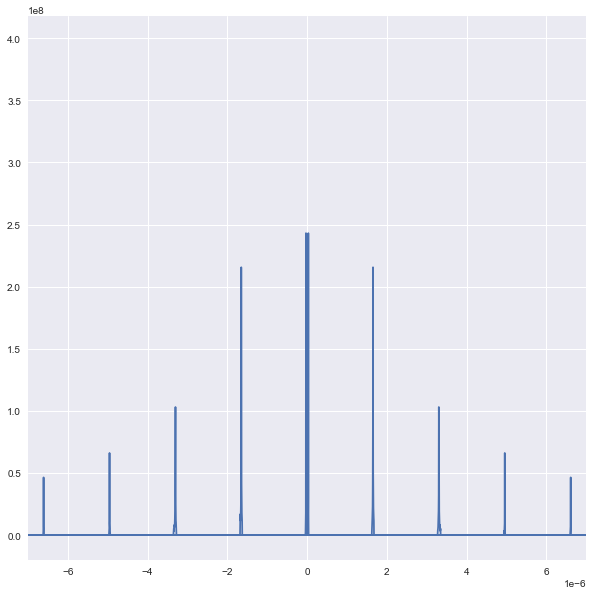

In [24]:
plt.figure(figsize=(10,10))
plt.plot(f, np.abs(F_filt))
plt.xlim(-0.000007, 0.000007)

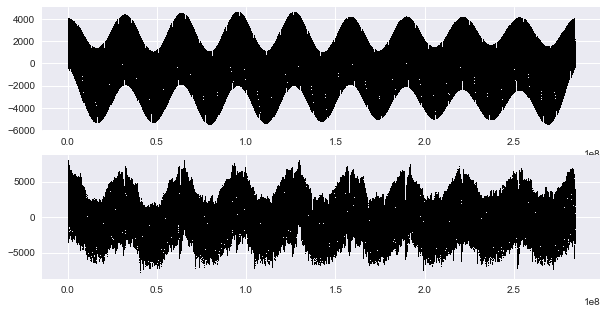

In [25]:
plt.figure(figsize=(10,5))
plt.subplot(211)
plt.plot(Electric.Seconds ,np.fft.ifft(F_filt).real, ',k')

plt.subplot(212)
plt.plot(Electric.Seconds, Vol_shift, ',k')

Text(0.5, 1.0, 'Dati reali - dati filtrati')

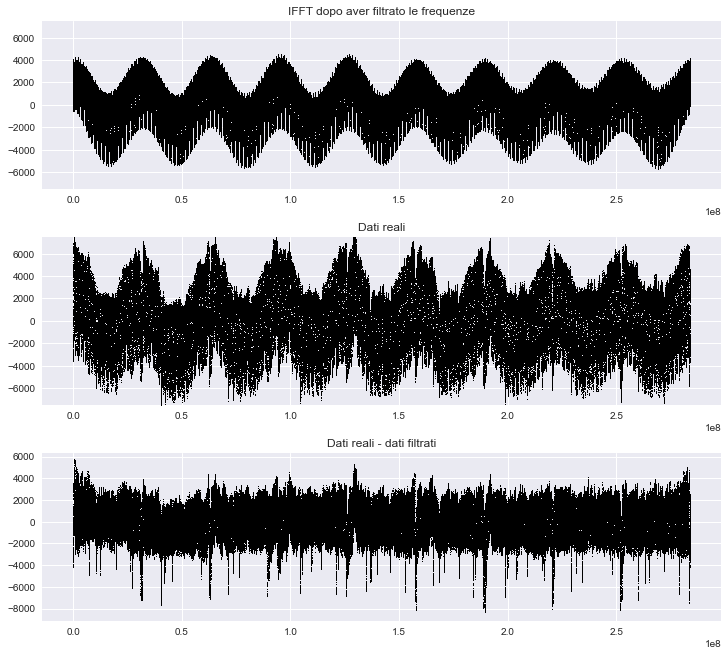

In [26]:
F = np.fft.fft(Vol_shift)

F_abs = np.abs(F)

peaks, _ = signal.find_peaks(F_abs, threshold=8E6, distance=200)
widths = signal.peak_widths(F_abs, peaks, rel_height=0.97)

F_filt = np.zeros(len(F), dtype='complex')
for i in range(len(widths[2])):
    F_filt[int(widths[2][i]):int(widths[3][i])] = F[int(widths[2][i]):int(widths[3][i])]
    

fig, axs = plt.subplots(3, 1, figsize=(10,9), constrained_layout=True)
axs[0].plot(Electric.Seconds ,np.fft.ifft(F_filt).real, ',k')
axs[0].set_title('IFFT dopo aver filtrato le frequenze')
axs[0].set_ylim(-7500, 7500)

axs[1].plot(Electric.Seconds, Vol_shift, ',k')
axs[1].set_title('Dati reali')
axs[1].set_ylim(-7500, 7500)

axs[2].plot(Electric.Seconds, Vol_shift - np.fft.ifft(F_filt).real, ',k')
axs[2].set_title('Dati reali - dati filtrati')

(array([1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 2.000e+00, 1.000e+00,
        3.000e+00, 2.000e+00, 2.000e+00, 3.000e+00, 3.000e+00, 4.000e+00,
        1.000e+00, 4.000e+00, 5.000e+00, 6.000e+00, 5.000e+00, 6.000e+00,
        5.000e+00, 6.000e+00, 6.000e+00, 7.000e+00, 5.000e+00, 1.100e+01,
        6.000e+00, 9.000e+00, 4.000e+00, 9.000e+00, 8.000e+00, 4.000e+00,
        6.000e+00, 7.000e+00, 8.000e+00, 1.200e+01, 8.000e+00, 7.000e+00,
        8.000e+00, 1.300e+01, 1.500e+01, 1.000e+01, 2.000e+01, 1.700e+01,
        1.900e+01, 2.500e+01, 1.800e+01, 2.500e+01, 1.700e+01, 1.900e+01,
        1.800e+01, 1.800e+01, 1.600e+01, 1.900e+01, 1.500e+01, 2.000e+01,
        2.500e+01, 2.200e+01, 2.000e+01, 1.800e+01, 1.900e+01, 2.500e+01,
        3.200e+01, 3.200e+01, 2.700e+01, 3.000e+01, 3.000e+01, 3.400e+01,
        2.900e+01, 1.800e+01, 1.800e+01, 2.300e+01, 3.000e+01, 2.600e+01,
        2.100e+01, 2.000e+01, 2.900e+01, 2.600e+01, 1.800e+01, 2.800e+01,
        3.100e+01, 2.600e+01, 2.500e+0

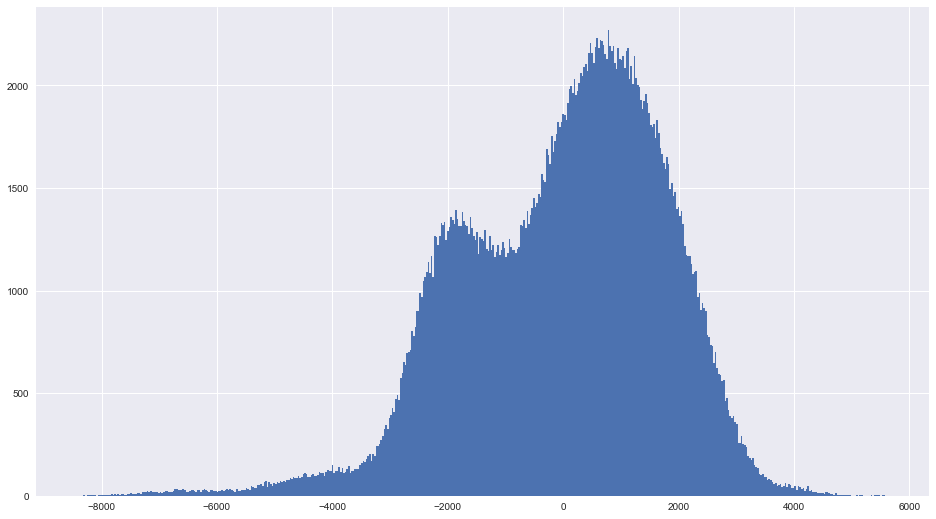

In [27]:
plt.hist(Vol_shift - np.fft.ifft(F_filt).real, bins=500)

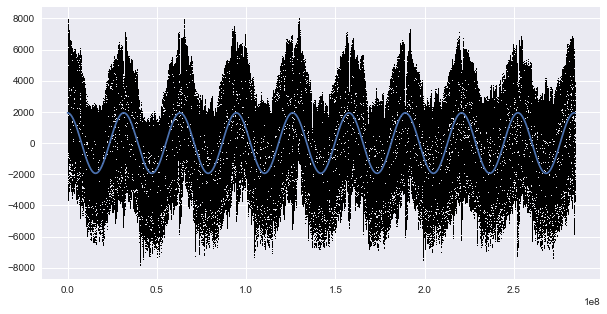

In [28]:
t = Electric.Seconds.values
freq = 3.171E-8
phase = np.angle(np.fft.ifft(F_filt)).mean()
plt.figure(figsize=(10,5))
plt.plot(Electric.Seconds, Vol_shift, ',k')
plt.plot(t, np.abs(np.fft.ifft(F_filt)).mean() * np.cos(2*np.pi*freq*t + phase))
#plt.plot(t, np.abs(np.fft.ifft(F_filt)).mean() * np.cos(2*np.pi*freq*t ))

In [29]:
phase, np.pi/2

(0.01698376181711962, 1.5707963267948966)

# FFT su periodi più piccoli

Text(0.5, 1.0, 'FFT in Frequency Domain')

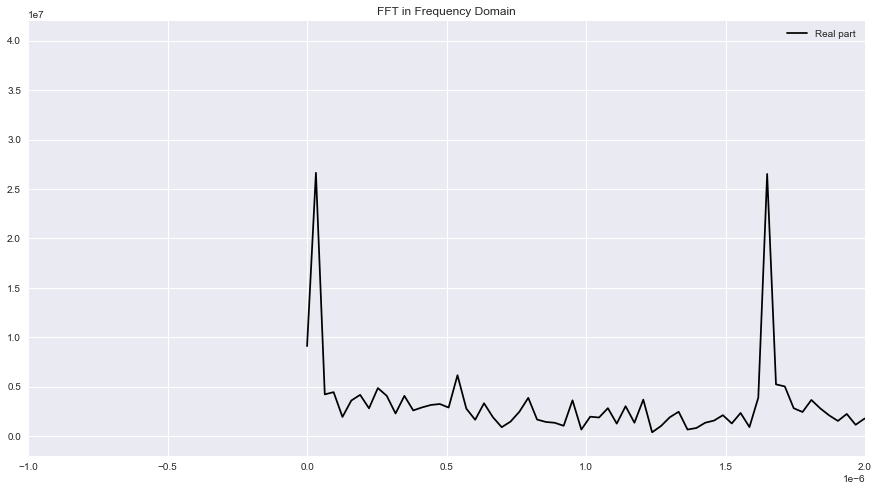

In [30]:
F = np.fft.fft(Vol_shift[:35040])
ts = (Electric.Seconds.iloc[-1] - Electric.Seconds.iloc[0])/(Electric.Seconds.size -1)
freq = np.fft.fftfreq(n=Electric.Load[:35040].size, d=1/ts)
f = np.linspace(0, 1/(2*ts), Electric.Load[:35040].size//2, endpoint=True)

plt.figure(figsize=(15,8))
#plt.plot(freq[:len(freq)//2], np.abs(F[:len(freq)//2]), c='k', label="Real part")
plt.plot(f, np.abs(F[:len(freq)//2]), c='k', label="Real part")
plt.legend(loc=1)
#plt.xlim(0,50)
plt.xlim(-0.000001,0.000002)
plt.title("FFT in Frequency Domain")

In [31]:
np.abs(F[:len(freq)//2])[f < 0.000002].max(), f[np.abs(F[:len(freq)//2])[f < 0.000002].argmax()]

(26630226.20759746, 3.1711602006710174e-08)

Text(0.5, 1.0, 'FFT in Frequency Domain')

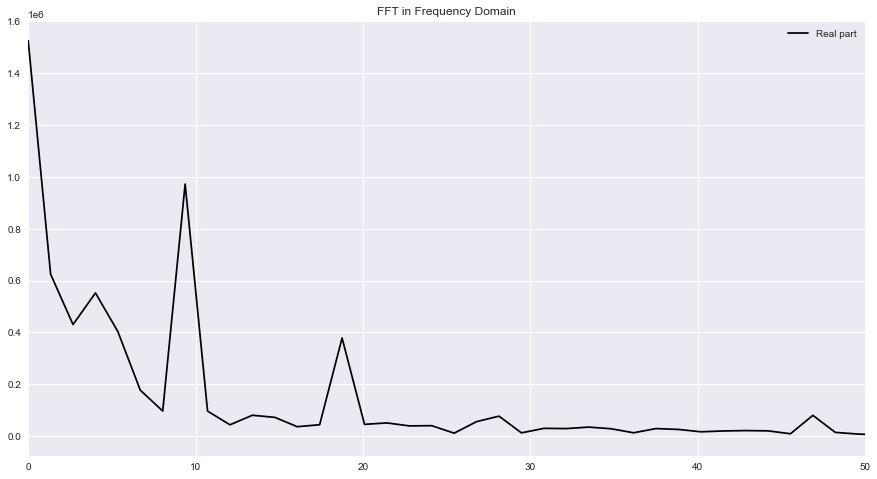

In [32]:
F = np.fft.fft(Vol_shift[:672])
ts = (Electric.Seconds.iloc[-1] - Electric.Seconds.iloc[0])/(Electric.Seconds.size -1)
freq = np.fft.fftfreq(n=Electric.Load[:672].size, d=1/ts)

plt.figure(figsize=(15,8))
plt.plot(freq[:len(freq)//2], np.abs(F[:len(freq)//2]), c='k', label="Real part")
plt.legend(loc=1)
plt.xlim(0,50)
plt.title("FFT in Frequency Domain")

Text(0.5, 1.0, 'FFT in Frequency Domain')

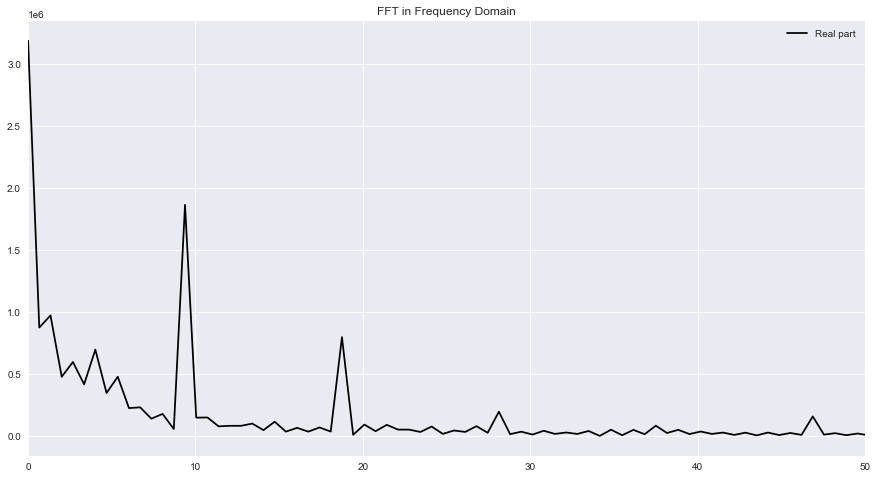

In [33]:
F = np.fft.fft(Vol_shift[:2*672])
ts = (Electric.Seconds.iloc[-1] - Electric.Seconds.iloc[0])/(Electric.Seconds.size -1)
freq = np.fft.fftfreq(n=Electric.Load[:2*672].size, d=1/ts)

plt.figure(figsize=(15,8))
plt.plot(freq[:len(freq)//2], np.abs(F[:len(freq)//2]), c='k', label="Real part")
plt.legend(loc=1)
plt.xlim(0,50)
plt.title("FFT in Frequency Domain")

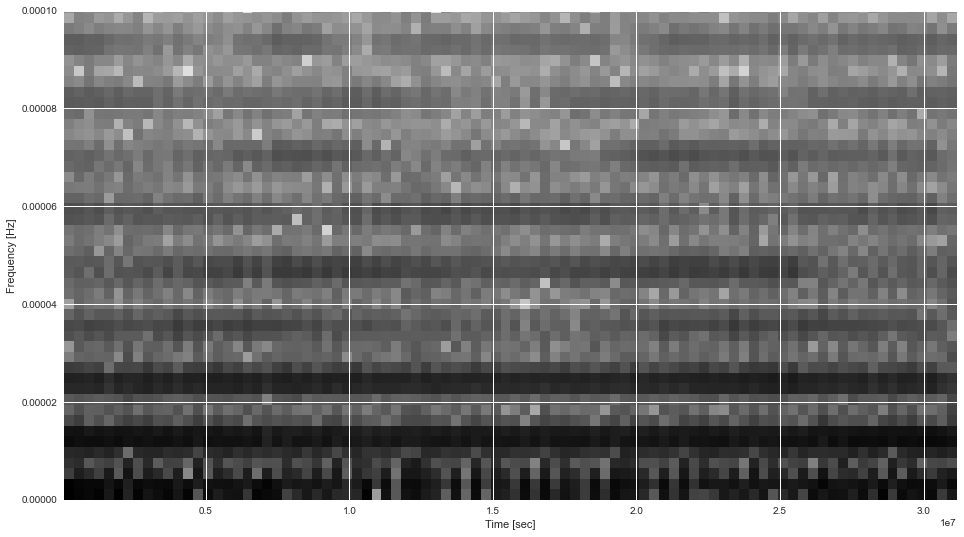

In [34]:
plt.specgram(Vol_shift[:35040], Fs=1/ts, NFFT=512)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.ylim(0, 0.0001);

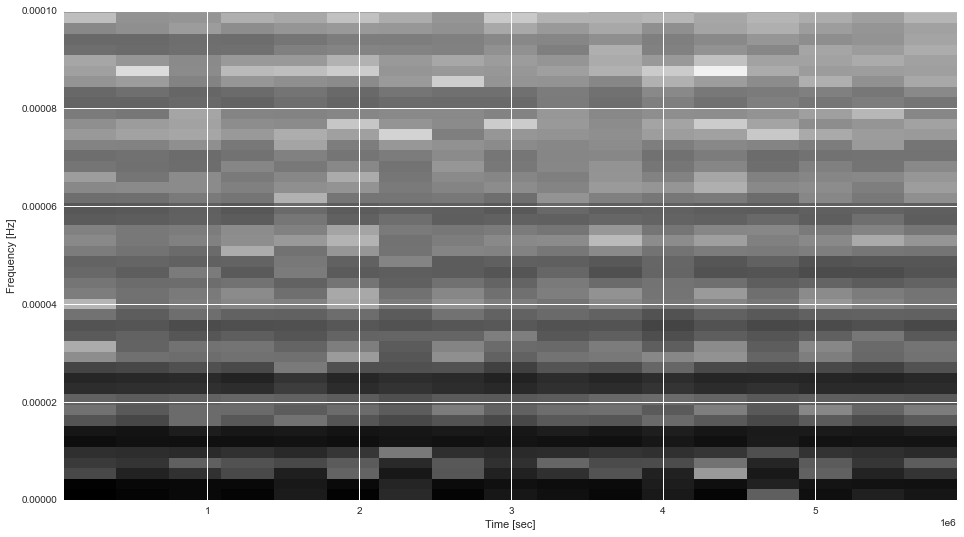

In [35]:
plt.specgram(Vol_shift[0:10*672], Fs=1/ts, NFFT=512)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.ylim(0, 0.0001);

# wavelet 

[13, 15, 15]


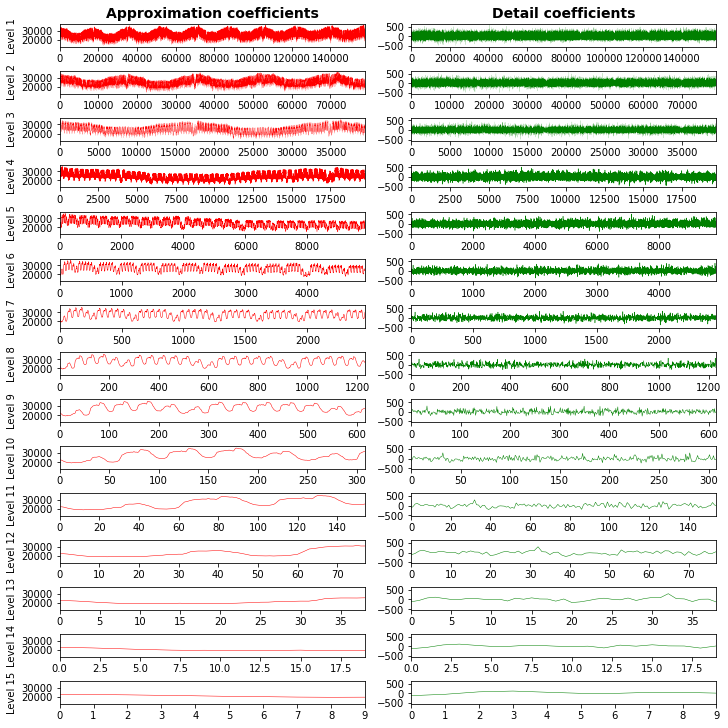

In [5]:
print([pywt.dwt_max_level(len(Electric), wavelet) for wavelet in ['coif5', 'sym4', 'sym5']])
_, cl = wavelet_coeffs_plot(df=Electric, waveletname='sym4')

(array([  1.,   0.,   2.,   0.,   2.,   3.,   4.,   9.,   8.,  23.,  23.,
         36.,  63.,  85.,  80.,  98., 120., 159., 192., 189., 201., 200.,
        172., 182., 156., 137.,  95.,  81.,  56.,  56.,  32.,  25.,  17.,
         14.,  11.,   7.,   3.,   4.,   1.,   1.,   3.]),
 array([-370.71979963, -352.99513739, -335.27047515, -317.54581291,
        -299.82115068, -282.09648844, -264.3718262 , -246.64716396,
        -228.92250173, -211.19783949, -193.47317725, -175.74851501,
        -158.02385278, -140.29919054, -122.5745283 , -104.84986607,
         -87.12520383,  -69.40054159,  -51.67587935,  -33.95121712,
         -16.22655488,    1.49810736,   19.2227696 ,   36.94743183,
          54.67209407,   72.39675631,   90.12141855,  107.84608078,
         125.57074302,  143.29540526,  161.02006749,  178.74472973,
         196.46939197,  214.19405421,  231.91871644,  249.64337868,
         267.36804092,  285.09270316,  302.81736539,  320.54202763,
         338.26668987,  355.9913521 ]),


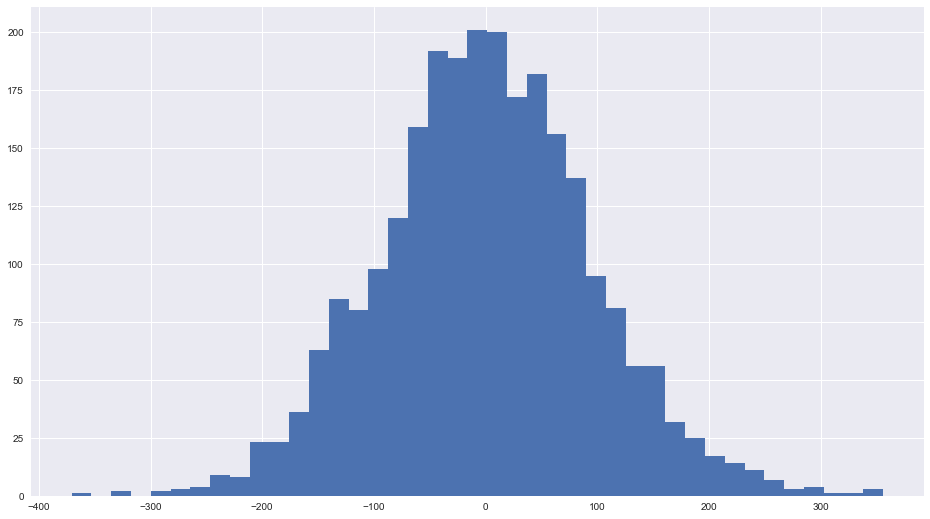

In [10]:
plt.hist(cl, bins='auto')

# ACF PACF E ARIMA

In [36]:
tmp = Electric.copy()
tmp.set_index('Date', inplace=True)
tmp

,Seconds,Load,Day,Minutes,Hour
Date,,,,,
2008-01-01 00:15:00,0.0,15938.8,Tuesday,15,0
2008-01-01 00:30:00,900.0,15770.4,Tuesday,30,0
2008-01-01 00:45:00,1800.0,15766.3,Tuesday,45,0
2008-01-01 01:00:00,2700.0,15415.2,Tuesday,0,1
2008-01-01 01:15:00,3600.0,15351.8,Tuesday,15,1
...,...,...,...,...,...
2016-12-31 23:00:00,284078700.0,15952.7,Saturday,0,23
2016-12-31 23:15:00,284079600.0,15865.3,Saturday,15,23
2016-12-31 23:30:00,284080500.0,15693.5,Saturday,30,23


## Weekly Load Mean

In [37]:
weekly_Load = tmp.resample('w').mean()
weekly_Load = weekly_Load['Load']

/home/wronsmin/.local/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


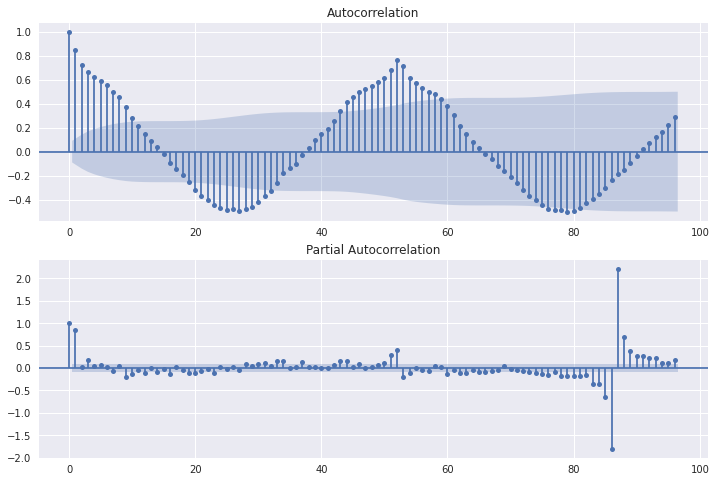

In [38]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
lag = 4*12*2
fig = sm.graphics.tsa.plot_acf(weekly_Load, lags=lag, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(weekly_Load, lags=lag, ax=ax2)

In [39]:
from statsmodels.tsa.stattools import adfuller

adfuller(weekly_Load, autolag=None, maxlag=1)

(-5.865316457785154,
 3.3361593497098533e-07,
 1,
 468,
 {'1%': -3.4444002781824477,
  '5%': -2.867735576537528,
  '10%': -2.57007000456571})

In [57]:
%%time 
from statsmodels.tsa.statespace.sarimax import SARIMAX

# (2,0,11)x(1,1,0,52)
model = SARIMAX(weekly_Load, order=(2,0,11), seasonal_order=(1,1,0,52))
results = model.fit()
print(results.summary())

/home/wronsmin/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


                                      SARIMAX Results                                       
Dep. Variable:                                 Load   No. Observations:                  470
Model:             SARIMAX(2, 0, 11)x(1, 1, [], 52)   Log Likelihood               -3293.144
Date:                              Mon, 21 Dec 2020   AIC                           6616.288
Time:                                      09:37:51   BIC                           6676.821
Sample:                                  01-06-2008   HQIC                          6640.218
                                       - 01-01-2017                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2446      0.538      0.455      0.649      -0.810       1.299
ar.L2          0.08

Text(0.5, 1.0, 'Poland Load')

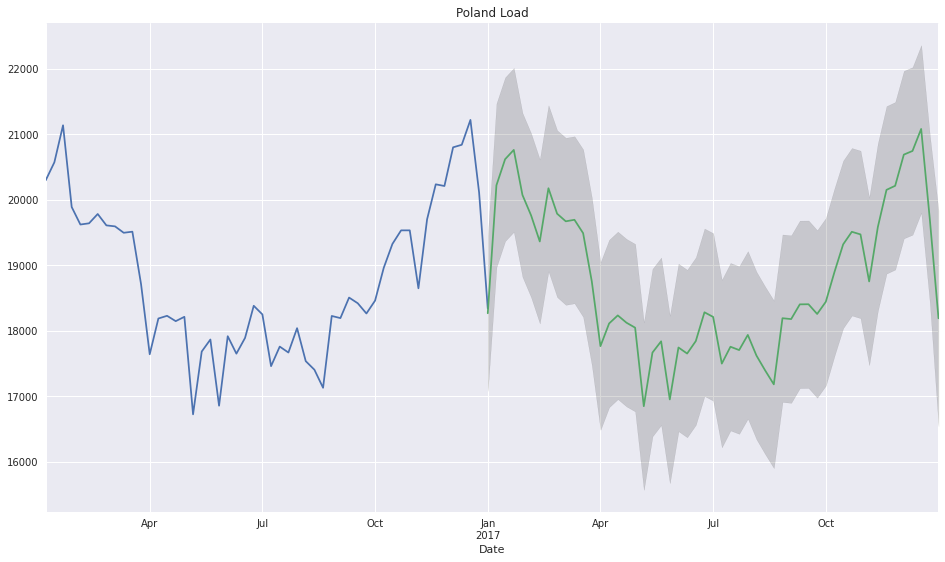

In [60]:
forecast = results.get_prediction(start=weekly_Load.index[-1], end=weekly_Load.index[-1] + pd.DateOffset(weeks=52), dynamic= True)

weekly_Load[-52:].plot()
forecast.predicted_mean.plot()
plt.fill_between(forecast.conf_int().index, forecast.conf_int()['lower Load'], forecast.conf_int()['upper Load'], color='k', alpha=0.15)
plt.title('Poland Load')

## Daily Load Mean

In [42]:
daily_Load = tmp.resample('d').mean()
daily_Load = daily_Load['Load']

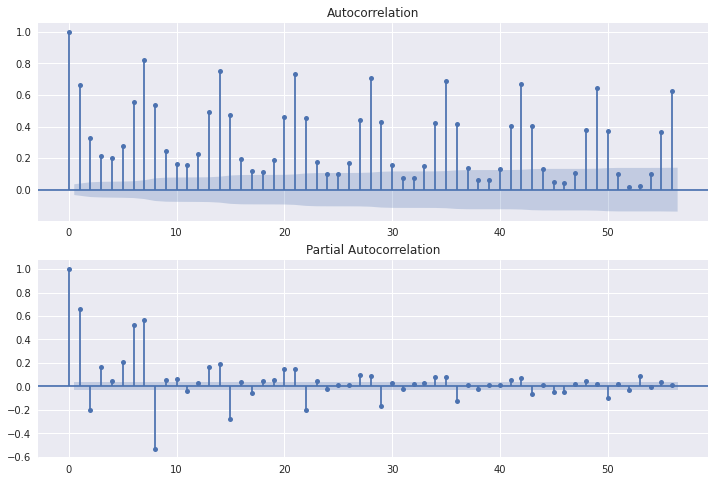

In [62]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
lag = 7*4*2
fig = sm.graphics.tsa.plot_acf(daily_Load, lags=lag, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(daily_Load, lags=lag, ax=ax2)

In [44]:
adfuller(daily_Load, autolag=None, maxlag=1)

(-28.769167246810245,
 0.0,
 1,
 3287,
 {'1%': -3.43234099912876,
  '5%': -2.862419705448909,
  '10%': -2.5672382855426354})

In [63]:
%%time 

# (4,0,5) x (1,1,0,7)
model = SARIMAX(daily_Load, order=(4,0,23), seasonal_order=(1,1,0,7))
results = model.fit()

/home/wronsmin/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


CPU times: user 6min 59s, sys: 15min 24s, total: 22min 24s
Wall time: 2min 4s


Text(0.5, 1.0, 'Poland Load')

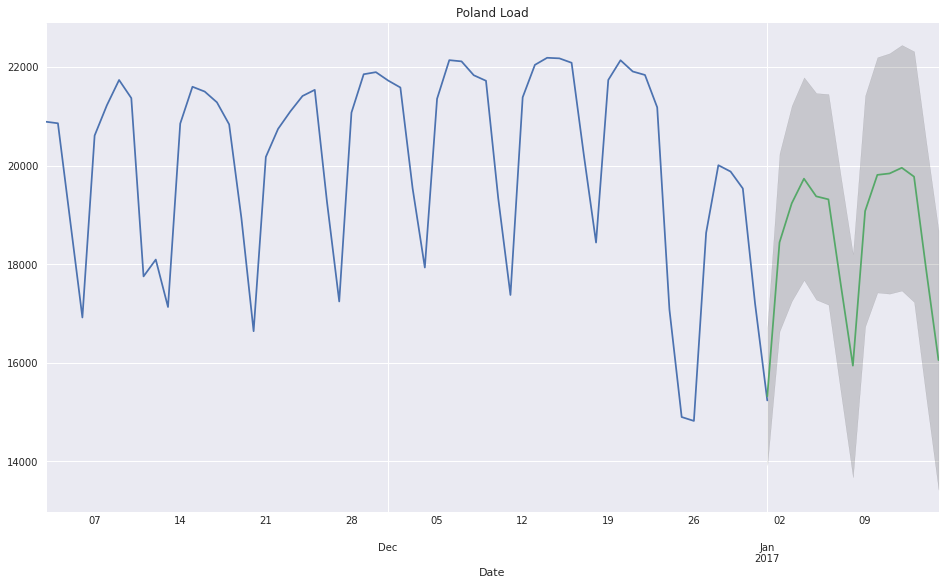

In [64]:
forecast = results.get_prediction(start=daily_Load.index[-1], end=daily_Load.index[-1] + pd.DateOffset(days=14), dynamic= True)

daily_Load[-60:].plot()
forecast.predicted_mean.plot()
plt.fill_between(forecast.conf_int().index, forecast.conf_int()['lower Load'], forecast.conf_int()['upper Load'], color='k', alpha=0.15)
plt.title('Poland Load')

# Calculate the PSF

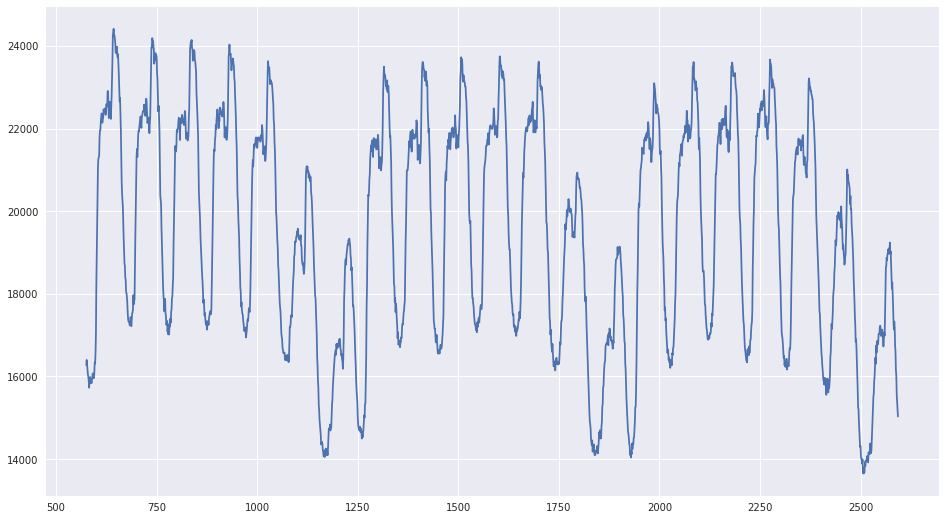

In [47]:
plt.plot(Electric.Load[575:575+3*673])

In [ ]:
from functools import reduce

url_template  = 'https://www.timeanddate.com/holidays/poland/'

dates = []
for year in range(2000, 2020):
    dates.append(pd.read_html(url_template + str(year))[0].dropna()['Date']['Date'].values)
    
common_dates = reduce(np.intersect1d, dates)
df_festivities = pd.read_html(url_template)[0].droplevel(0, axis=1).dropna().reset_index(drop=True)
df_festivities = df_festivities[df_festivities.Date.isin(common_dates)]
df_festivities.rename(columns={df_festivities.columns[1]: 'Week Day'}, inplace=True)

df_festivities[['Day', 'Month']] = df_festivities['Date'].str.split(expand=True)
cols = df_festivities.columns.to_list()
df_festivities = df_festivities[cols[-2:] + cols[:-2]]
df_festivities.drop(columns='Date', inplace=True)



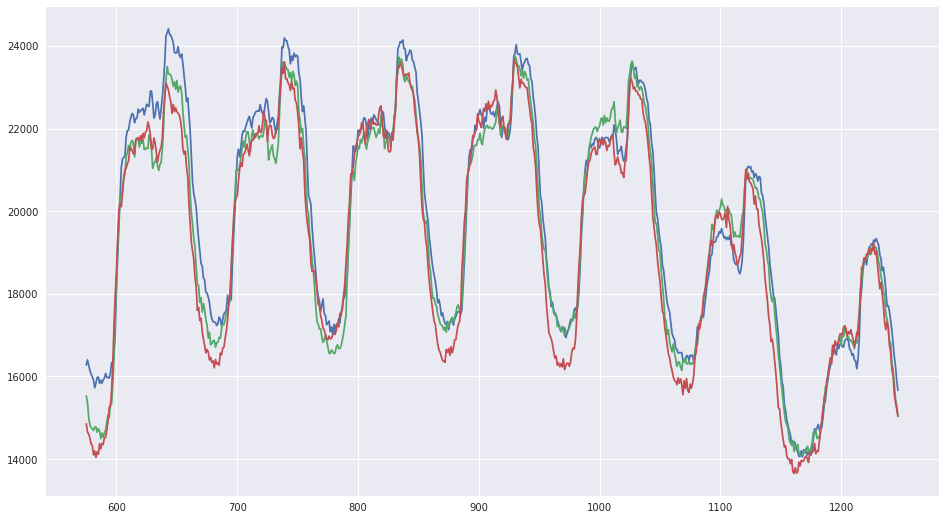

In [48]:
for i in range(3):
    plt.plot(np.arange(575,575 + 673),Electric.Load[575+i*673:575+(i+1)*673])

In [49]:
Volume_mean = Electric.groupby(['Day', 'Hour','Minutes'], as_index=False)['Load'].mean().copy()
ordered_days = ['Monday','Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
Volume_mean['Day'] = pd.Categorical(Volume_mean['Day'], categories=ordered_days, ordered=True)
Volume_mean = Volume_mean.sort_values(['Day', 'Hour', 'Minutes'], ignore_index=1)

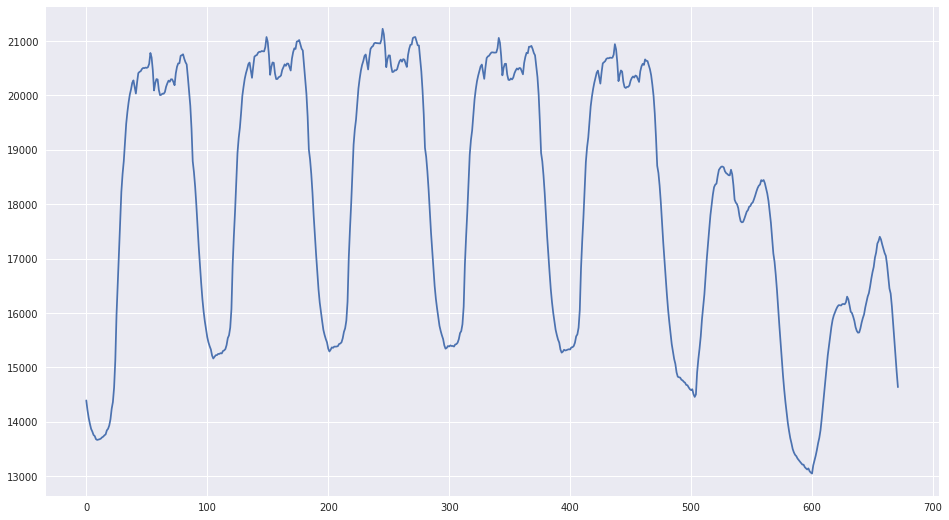

In [50]:
plt.plot(Volume_mean['Load'])

In [51]:
Volume_mean

,Day,Hour,Minutes,Load
0,Monday,0,0,14391.715139
1,Monday,0,15,14212.926866
2,Monday,0,30,14071.291684
3,Monday,0,45,13961.918550
4,Monday,1,0,13868.726652
...,...,...,...,...
667,Sunday,22,45,15832.074414
668,Sunday,23,0,15518.033262
669,Sunday,23,15,15209.923028
670,Sunday,23,30,14909.074414


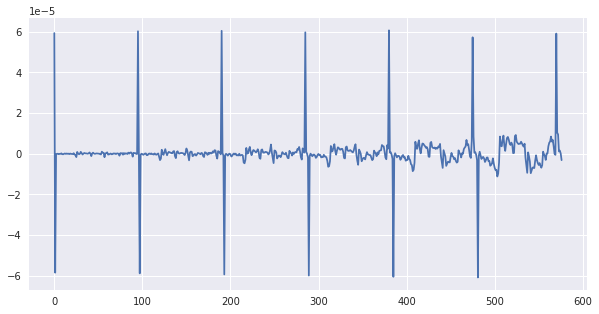

In [52]:
plt.figure(figsize=(10,5))

w = np.zeros(96*7)
for i in range(7):
    w[95*i] = Volume_mean.loc[Volume_mean.Day == ordered_days[i], 'Load'].max() / Volume_mean['Load'].max()

i = ordered_days[3]
#conv = signal.fftconvolve(w, Volume_mean.loc[Volume_mean.Day == i, 'Load'], mode='same')
deconv = signal.deconvolve(w, Volume_mean.loc[Volume_mean.Day == i, 'Load'])[0]
plt.plot(deconv)

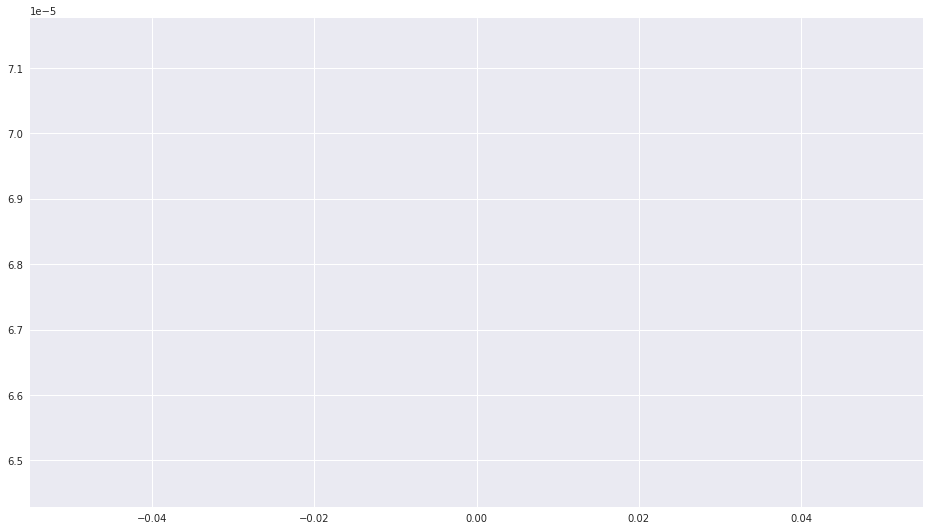

In [53]:
#conv_p = signal.fftconvolve(w, Volume_mean.Load.values, mode='same')
deconv_p = signal.deconvolve(w, Volume_mean.Load.values)[0]

plt.plot(deconv_p)

(array([  6.,   0.,   0.,   0., 255., 309.,   0.,   0.,   0.,   7.]),
 array([-6.08613422e-05, -4.87053006e-05, -3.65492590e-05, -2.43932174e-05,
        -1.22371759e-05, -8.11342797e-08,  1.20749073e-05,  2.42309489e-05,
         3.63869905e-05,  4.85430321e-05,  6.06990736e-05]),
 <BarContainer object of 10 artists>)

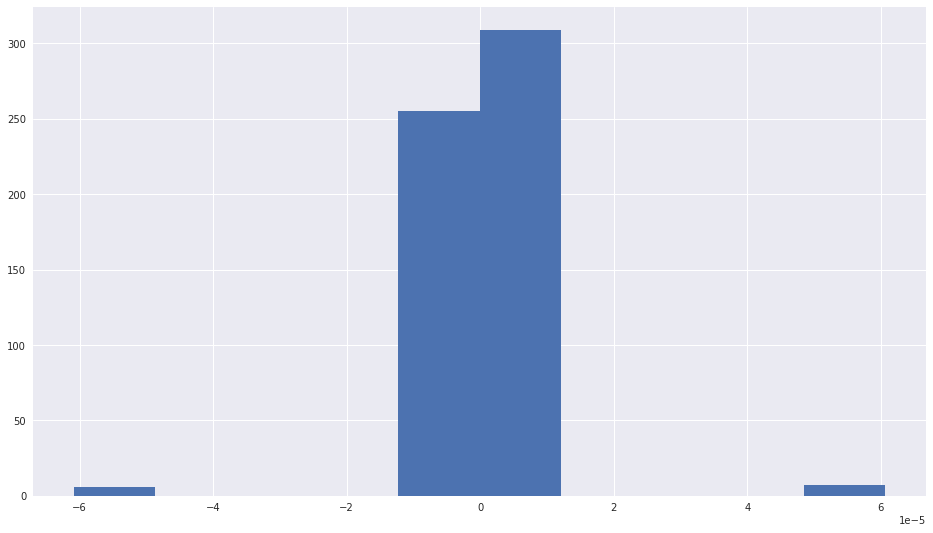

In [54]:
plt.hist(deconv)

# References
1. [Deconvolution](https://stackoverflow.com/questions/17473917/is-there-a-equivalent-of-scipy-signal-deconvolve-for-2d-arrays), numpy stackoverflow
2. Nonstationary [Predictive](https://www.crewes.org/ForOurSponsors/ResearchReports/2009/CRR200958.pdf) Deconvolution